In [1]:
import sys
sys.path.append('/home/guido/.local/lib/python2.7/site-packages/horton')
import horton as horton
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [109]:
def get_hf_density(coordinates, mixing_value, grid):
    horton.log.set_level(0)
    mol = horton.IOData()
    mol.coordinates = coordinates
    mol.numbers = np.array([7., 7.])
    mol.pseudo_numbers = np.array([7., 7.]) + np.array([-1., 1.]) * mixing_value
    
    # build basis set
    basisset = 'def2-qzvp' #'6-31G(d)'
    obasis = horton.get_gobasis(mol.coordinates, np.array([7, 7]), basisset)
    obasis2 = horton.get_gobasis(mol.coordinates, np.array([8, 8]), basisset)
    obasis.concatenate(obasis2)
    olp = obasis.compute_overlap()
    kin = obasis.compute_kinetic()
    na = obasis.compute_nuclear_attraction(mol.coordinates, mol.pseudo_numbers)
    er = obasis.compute_electron_repulsion()
    
    orb_alpha = horton.Orbitals(obasis.nbasis)
    orb_beta = horton.Orbitals(obasis.nbasis)
    
    one = kin + na
    horton.guess_core_hamiltonian(olp, one, orb_alpha, orb_beta)
    
    external = {'nn': horton.compute_nucnuc(mol.coordinates, mol.pseudo_numbers)}
    
    terms = [horton.UTwoIndexTerm(kin, 'kin'), horton.UDirectTerm(er, 'hartree'), horton.UExchangeTerm(er, 'x_hf'), horton.UTwoIndexTerm(na, 'ne')]
    ham = horton.UEffHam(terms, external)
    occ_model = horton.AufbauOccModel(7, 7)
    occ_model.assign(orb_alpha, orb_beta)
    dm_alpha = orb_alpha.to_dm()
    dm_beta = orb_beta.to_dm()
    scf_solver = horton.EDIIS2SCFSolver(1e-5, maxiter=400)
    scf_solver(ham, olp, occ_model, dm_alpha, dm_beta)
    
    fock_alpha = np.zeros(olp.shape)
    fock_beta = np.zeros(olp.shape)
    ham.reset(dm_alpha, dm_beta)
    energy = ham.compute_energy()
    ham.compute_fock(fock_alpha, fock_beta)
    orb_alpha.from_fock_and_dm(fock_alpha, dm_alpha, olp)
    orb_beta.from_fock_and_dm(fock_beta, dm_beta, olp)

    # integration grid
    rho_alpha = obasis.compute_grid_density_dm(dm_alpha, grid.points)
    rho_beta = obasis.compute_grid_density_dm(dm_beta, grid.points)
    rho_full = rho_alpha + rho_beta
    
    return energy, rho_full, external['nn']

def build_cache():
    ret = []
    grids = {}
    densities = {}
    for bond_length in np.hstack((np.linspace(1, 2.5, 11), np.linspace(3, 5, 5), [10.] )):
        # build grid
        coordinates = np.array([[0.0, 0.0, -bond_length/2.], [0.0, 0.0, bond_length/2.]])
        grids[bond_length] = horton.BeckeMolGrid(coordinates, np.array([7, 7]), np.array([7.,7.]), 'insane', mode='keep', random_rotate=False)
        
        density_path = {}
        for mixing_value in np.linspace(0, 1, 10):
            try:
                ener, den, nuc = get_hf_density(coordinates, mixing_value, grids[bond_length])
            except:
                continue
            ret.append({'bond': bond_length, 'mixing': mixing_value, 'energy': ener, 'density': den, 'Enn': nuc})
        densities[bond_length] = density_path
    return grids, pd.DataFrame(ret)
griddb, cache = build_cache()

In [115]:
def integrate():
    ret = []
    for distance, subcache in cache.groupby('bond'):
        grid = griddb[distance]
        
        mixing_values = subcache.mixing.values
        densities = subcache.density.values
        
        rhotilde = np.trapz(densities, mixing_values, axis=0)
        
        coordinates = np.array([[0.0, 0.0, -distance/2.], [0.0, 0.0, distance/2.]])
        for atom in range(2):
            contribution = -grid.integrate(rhotilde / np.linalg.norm(grid.points - coordinates[atom], axis=1))
            ret.append({'distance': distance, 'site': atom, 'energy': contribution})
    return pd.DataFrame(ret)
siteneergies = integrate()

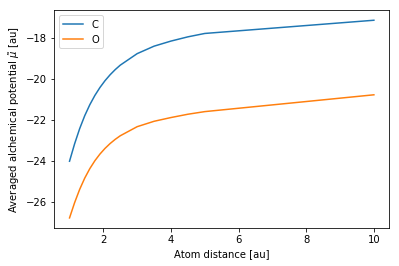

In [116]:
plt.xlabel('Atom distance [au]')
plt.ylabel(r'Averaged alchemical potential $\tilde\mu$ [au]')
elements = 'CO'
for name, group in siteneergies.groupby('site'):
    plt.plot(group.distance, group.energy, label=elements[name])
plt.legend()

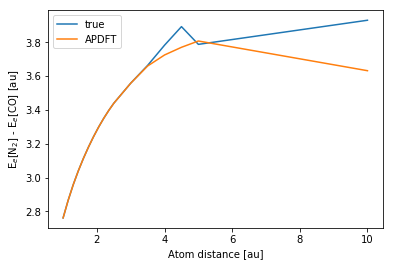

In [117]:
s = cache.query("mixing == 0")
s2 = cache.query("mixing == 1")
plt.ylabel('E$_e$[N$_2$] - E$_e$[CO] [au]')
plt.xlabel('Atom distance [au]')
plt.plot(s.bond, (s.energy.values - s.Enn.values) - (s2.energy.values - s2.Enn.values), label='true')

energies = []
for name, group in siteneergies.groupby('site'):
    energies.append(group.energy.values)
plt.plot(group.distance, energies[0] - energies[1], label='APDFT')
plt.legend()


-74.81862932487545
-37.69362722184166
-54.4043853046568


Text(0,0.5,'Electronic energy [au]')

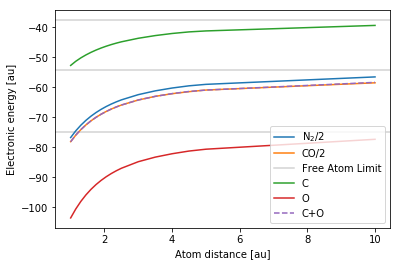

In [132]:
s = cache.query("mixing == 0")
nref = (s.energy.values-s.Enn.values)/2
plt.plot(s.bond, nref, label='N$_2$/2')
s2 = cache.query("mixing == 1")
plt.plot(s2.bond, (s2.energy.values-s2.Enn.values)/2, label='CO/2')
elements = 'CO'
signs = [-1, 1]
svals = []
first = True
for numbers, freeatomenergy in atom_energies.items():
    print freeatomenergy
    label = None
    if first:
        label='Free Atom Limit'
    first = False
    plt.axhline(freeatomenergy, color='lightgrey', zorder=-10, label=label)
for name, group in siteneergies.groupby('site'):
    svals.append(nref + signs[name]*group.energy.values)
    plt.plot(group.distance, svals[-1], label=elements[name])
plt.plot(group.distance, sum(svals)/2, '--', label='C+O')
plt.legend()
plt.xlabel('Atom distance [au]')
plt.ylabel('Electronic energy [au]')

-74.81862932487545
-37.69362722184166
-54.4043853046568


Text(0,0.5,'Total energy [au]')

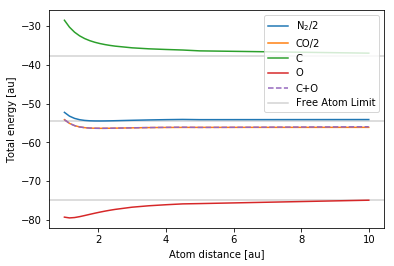

In [121]:
s = cache.query("mixing == 0")
nref = (s.energy.values)/2
plt.plot(s.bond, nref, label='N$_2$/2')
s2 = cache.query("mixing == 1")
plt.plot(s2.bond, (s2.energy.values)/2, label='CO/2')
elements = 'CO'
signs = [-1, 1]
svals = []
for name, group in siteneergies.groupby('site'):
    svals.append(nref + signs[name]*group.energy.values)
    plt.plot(group.distance, svals[-1]- s.Enn.values/4 + s2.Enn.values/4, label=elements[name])
plt.plot(group.distance, sum(svals)/2 - s.Enn.values/2 + s2.Enn.values/2 , '--', label='C+O')
first = True
for numbers, freeatomenergy in atom_energies.items():
    print freeatomenergy
    label = None
    if first:
        label='Free Atom Limit'
    first = False
    plt.axhline(freeatomenergy, color='lightgrey', zorder=-10, label=label)
    
plt.legend()
plt.xlabel('Atom distance [au]')
plt.ylabel('Total energy [au]')

In [120]:
def get_free_atom_energy(Z, spins):
    horton.log.set_level(0)
    mol = horton.IOData()
    mol.coordinates = np.array([[0.0, 0.0, 0.0],])
    mol.numbers = np.array([Z,])
    mol.pseudo_numbers = np.array([Z,]) 
    
    # build basis set
    basisset = 'def2-qzvp' #'6-31G(d)'
    obasis = horton.get_gobasis(mol.coordinates, np.array([int(Z),]), basisset)
    olp = obasis.compute_overlap()
    kin = obasis.compute_kinetic()
    na = obasis.compute_nuclear_attraction(mol.coordinates, mol.pseudo_numbers)
    er = obasis.compute_electron_repulsion()
    
    orb_alpha = horton.Orbitals(obasis.nbasis)
    orb_beta = horton.Orbitals(obasis.nbasis)
    
    one = kin + na
    horton.guess_core_hamiltonian(olp, one, orb_alpha, orb_beta)
    
    external = {'nn': horton.compute_nucnuc(mol.coordinates, mol.pseudo_numbers)}
    
    terms = [horton.UTwoIndexTerm(kin, 'kin'), horton.UDirectTerm(er, 'hartree'), horton.UExchangeTerm(er, 'x_hf'), horton.UTwoIndexTerm(na, 'ne')]
    ham = horton.UEffHam(terms, external)
    occ_model = horton.AufbauOccModel(spins[0], spins[1])
    occ_model.assign(orb_alpha, orb_beta)
    dm_alpha = orb_alpha.to_dm()
    dm_beta = orb_beta.to_dm()
    scf_solver = horton.EDIIS2SCFSolver(1e-5, maxiter=400)
    scf_solver(ham, olp, occ_model, dm_alpha, dm_beta)
    
    fock_alpha = np.zeros(olp.shape)
    fock_beta = np.zeros(olp.shape)
    ham.reset(dm_alpha, dm_beta)
    energy = ham.compute_energy()    
    return energy
spins = {6:(4, 2), 7:(5, 2), 8: (5, 3)}
atom_energies = {_: get_free_atom_energy(_, spins[_]) for _ in (6, 7, 8)}

Text(0.5,0,'Mixing parameter $\\lamba')

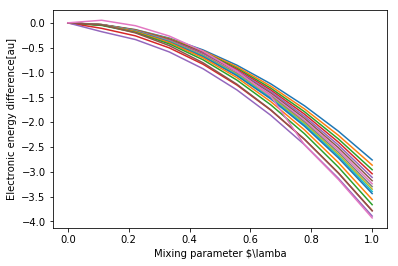

In [131]:
for name, group in cache.groupby('bond'):
    ys = group.energy.values - group.Enn.values
    plt.plot(group.mixing, ys-ys[0], label=name)
plt.ylabel('Electronic energy difference[au]')
plt.xlabel(r'Mixing parameter $\lamba')